In [1]:
from astropy import constants as cons
from astropy import units as un
import numpy as np
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
import matplotlib.pyplot as plt
import sys
plt.rcParams.update({'font.size': 20})

In [2]:
path = '/home/juanmanuel/Documents/Master/Thesis/Simulations'
folder = 'Relaxation'
simulation = 'mod12_60TAMS'
name = 'out0000.sph.ascii'

In [3]:
x, y, z, vx, vy, vz, m, d, u = np.genfromtxt('{}/{}/{}/{}'.format(path,folder,simulation,name),
                                          usecols= (0,1,2,3,4,5,6,7,8), unpack=True)

In [4]:
# Calculate the position and velocity of the center of mass.

xcm = x[np.argmax(d)]
ycm = y[np.argmax(d)]
zcm = z[np.argmax(d)]

vcmx = vx[np.argmax(d)]
vcmy = vy[np.argmax(d)]
vcmz = vz[np.argmax(d)]

new_x = (x-xcm)
new_y = (y-ycm)
new_z = (z-zcm)

new_vx = (vx-vcmx)
new_vy = (vy-vcmy)
new_vz = (vz-vcmz)

In [5]:
# Calculate the radius and velocity wrt the cm.

r = np.sqrt(new_x**2 + new_y**2 + new_z**2)
v = np.sqrt(new_vx**2 + new_vy**2 + new_vz**2)

# Index sorting the radius from lower to higher.

index = np.argsort(r)

# Reordering of all quantities based on Radius.
X = new_x[index]
Y = new_y[index]
Z = new_z[index]

VX = new_vx[index]
VY = new_vy[index]
VZ = new_vz[index]

R = r[index]
V = v[index]

U = u[index]
M = m[index]

In [6]:
# Generation of the enclosed mass profile.

Mencl = np.cumsum(M)

# Unit conversion for the gravitational constant.

G = ((cons.G)/((un.R_sun.to(un.m)**3))*(un.M_sun.to(un.kg))*((1.8845e-2*86400)**2)).value

# Energy calculation for the unbound mass criteria.

E = V**2 + U - G*Mencl/R

/tmp/ipykernel_1866/388932327.py:11: RuntimeWarning: divide by zero encountered in true_divide
  E = V**2 + U - G*Mencl/R


In [7]:
# Determination of the central radius where the potential energy aprox fails.

inner_R =  np.where(R > 2.5)[0][0]

# Bound unbound criteria for the mass.

unb = np.where(E[inner_R:] > 0)[0] + inner_R

bun_fin = np.where(E[inner_R:] <= 0)[0] + inner_R
bun_ini = np.where(R < R[inner_R])[0]
bun = np.concatenate((bun_ini,bun_fin))

percent = np.sum(M[unb])*100/np.sum(M)

Mencl_un = np.cumsum(M[unb])
R_un = R[unb]
Mencl_bn = np.cumsum(M[bun])
R_bn = R[bun]

In [8]:
percent

0.0

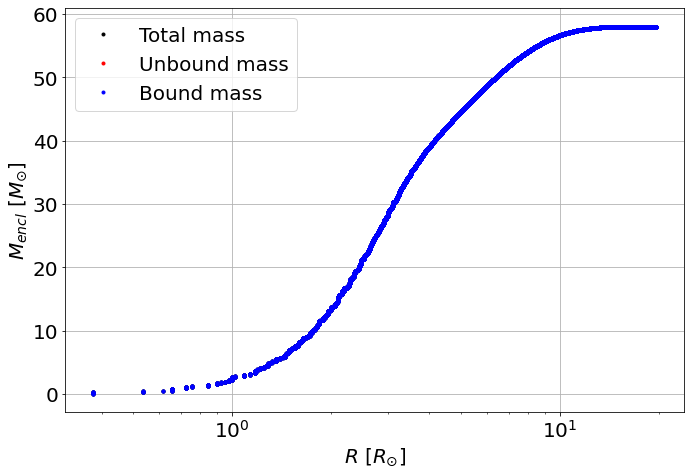

In [9]:
fig = plt.figure(figsize=(10, 7))

plt.plot(R,Mencl,'.k', label='Total mass')
plt.plot(R_un,Mencl_un,'.r', label='Unbound mass')
plt.plot(R_bn,Mencl_bn,'.b', label='Bound mass')
plt.xlabel("$R$ [$R_{\odot}$]")
plt.ylabel("$M_{encl}$ [$M_{\odot}$]")
plt.semilogx()
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
#plt.savefig('/tank0/ballone/coll_set/{}/'.format(folder)+name+'.png')

In [10]:
# Calculation of the angular momentum for the bounded particles.

Pos_bn = np.array([X[bun],Y[bun],Z[bun]])
Vel_bn = np.array([VX[bun],VY[bun],VZ[bun]])
P_bn = M[bun]*Vel_bn

L_bn = np.cross(Pos_bn,P_bn, axis = 0)

Lt_bn = np.array([np.sum(L_bn[0]),np.sum(L_bn[1]),np.sum(L_bn[2])])

In [11]:
#Generation of the rotation matrices.

if Lt_bn[2] > 0:
    thx = np.arctan(Lt_bn[1]/Lt_bn[2])
    Rx = np.array([[1,0,0],[0,np.cos(thx),-np.sin(thx)],[0,np.sin(thx),np.cos(thx)]])
    thy = -1*np.arctan(Rx.dot(Lt_bn)[0]/Rx.dot(Lt_bn)[2])
    Ry = np.array([[np.cos(thy),0,np.sin(thy)],[0,1,0],[-np.sin(thy),0,np.cos(thy)]])
    
else:
    thx = np.arctan(Lt_bn[1]/Lt_bn[2])
    Rx = np.array([[1,0,0],[0,np.cos(thx),-np.sin(thx)],[0,np.sin(thx),np.cos(thx)]])
    thy = -1*np.arctan(Rx.dot(Lt_bn)[0]/Rx.dot(Lt_bn)[2]) + np.pi
    Ry = np.array([[np.cos(thy),0,np.sin(thy)],[0,1,0],[-np.sin(thy),0,np.cos(thy)]])

In [12]:
# Rotation to align z vector along the bounded angular momentum.

Pos_bn_rot = Ry.dot(Rx.dot(Pos_bn))
Vel_bn_rot = Ry.dot(Rx.dot(Vel_bn))
P_bn_rot = M[bun]*Vel_bn_rot

# Conversion to a cylindrical coordinate system.

R_bn_rot = np.sqrt(Pos_bn_rot[0]**2+Pos_bn_rot[1]**2)
Vrad = (Vel_bn_rot[0]*Pos_bn_rot[0]+Vel_bn_rot[1]*Pos_bn_rot[1])/R_bn_rot
Vtan = (Vel_bn_rot[1]*Pos_bn_rot[0]-Vel_bn_rot[0]*Pos_bn_rot[1])/R_bn_rot
Vz = Vel_bn_rot[2]

#Conversion to km/s units.

Vrad = Vrad*(un.R_sun.to(un.km))/(1.8845e-2*86400)
Vtan = Vtan*(un.R_sun.to(un.km))/(1.8845e-2*86400)
Vz = Vz*(un.R_sun.to(un.km))/(1.8845e-2*86400)

/tmp/ipykernel_1866/4052645547.py:10: RuntimeWarning: invalid value encountered in true_divide
  Vrad = (Vel_bn_rot[0]*Pos_bn_rot[0]+Vel_bn_rot[1]*Pos_bn_rot[1])/R_bn_rot
/tmp/ipykernel_1866/4052645547.py:11: RuntimeWarning: invalid value encountered in true_divide
  Vtan = (Vel_bn_rot[1]*Pos_bn_rot[0]-Vel_bn_rot[0]*Pos_bn_rot[1])/R_bn_rot


In [13]:
#Generation of the histogram for Vr and Vtan.

at = np.histogram(R_bn_rot, bins=100,  weights= Vtan*M[bun])
bt = np.histogram(R_bn_rot, bins=100,  weights= M[bun])
Velt = (at[0]/bt[0])
mean_bint = (at[1][1:] + at[1][:-1]) / 2

ar = np.histogram(R_bn_rot, bins=100,  weights= Vrad*M[bun])
br = np.histogram(R_bn_rot, bins=100,  weights= M[bun])
Velr = (ar[0]/br[0])
mean_binr = (ar[1][1:] + ar[1][:-1]) / 2

az = np.histogram(R_bn_rot, bins=100,  weights= Vz*M[bun])
bz = np.histogram(R_bn_rot, bins=100,  weights= M[bun])
Velz = (az[0]/bz[0])
mean_binz = (az[1][1:] + az[1][:-1]) / 2

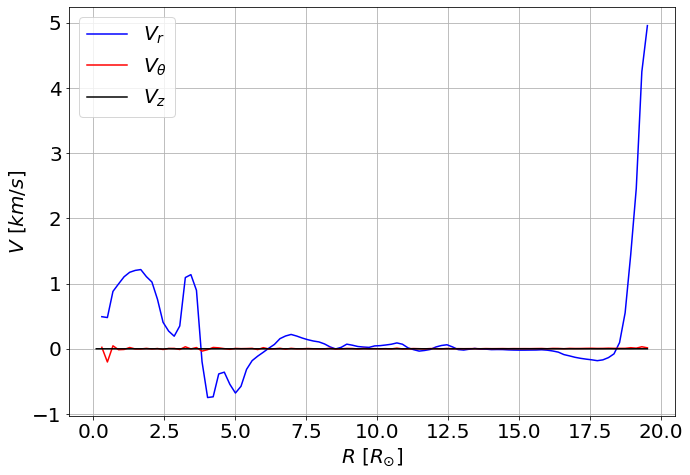

In [14]:
ig = plt.figure(figsize=(10, 7))

plt.plot(mean_binr,Velr,'-b', label = r'$V_{r}$')
plt.plot(mean_bint,Velt,'-r', label = r'$V_{\theta}$')
plt.plot(mean_binz,Velz,'-k', label = r'$V_{z}$')

plt.xlabel("$R$ $[R_{\odot}]$")
plt.ylabel("$V$ $[km/s]$")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()
#plt.savefig('/tank0/ballone/coll_set/{}/Vel_'.format(folder)+name+'.png')

In [27]:
perT, outT = np.genfromtxt('{}/{}/mod12_60TAMS/Munb_percent.txt'.format(path,folder), usecols= (0,1), unpack=True)
perZ, outZ = np.genfromtxt('{}/{}/mod12_40ZAMS/Munb_percent.txt'.format(path,folder), usecols= (0,1), unpack=True)

In [28]:
timeT = np.linspace(0,1.8445e-02*1*len(perT),len(perT))
timeZ = np.linspace(0,1.8445e-02*5*len(perZ),len(perZ))

In [29]:
outT[np.where(timeT > 2)[0][0]]

nan

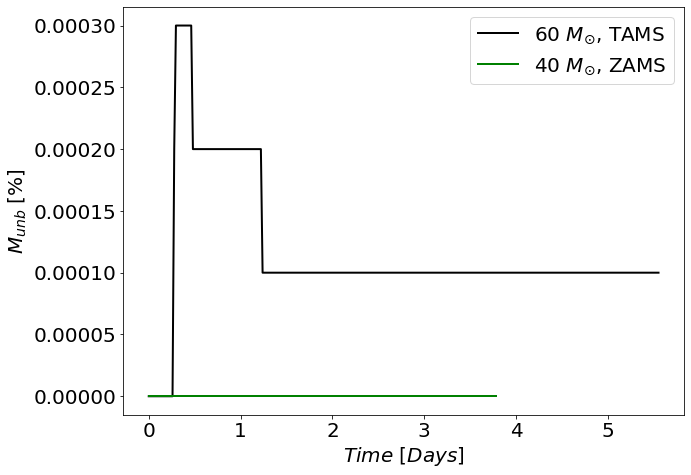

In [30]:
fig = plt.figure(figsize=(10, 7))

plt.plot(timeT,perT,'-k', linewidth=2., label = r'60 $M_{\odot}$, TAMS')
plt.plot(timeZ,perZ,'-g', linewidth=2., label = r'40 $M_{\odot}$, ZAMS')

#plt.xlim([1.3,15])
#plt.ylim([9,20])
plt.xlabel("$Time$ $[Days]$")
plt.ylabel("$M_{unb}$ $[\%]$")
#plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
VrT, VtT, VzT, stdrT, stdtT, stdzT = np.genfromtxt('{}/{}/mod12_60TAMS/L_evo.txt'.format(path,folder),
                                                   usecols= (0,1,2,3,4,5), unpack=True)
VrZ, VtZ, VzZ, stdrZ, stdtZ, stdzZ = np.genfromtxt('{}/{}/mod12_40ZAMS/L_evo.txt'.format(path,folder),
                                                   usecols= (0,1,2,3,4,5), unpack=True)

In [32]:
timeT = np.linspace(0,1.8445e-02*1*len(VrT),len(VrT))
timeZ = np.linspace(0,1.8445e-02*5*len(VrZ),len(VrZ))

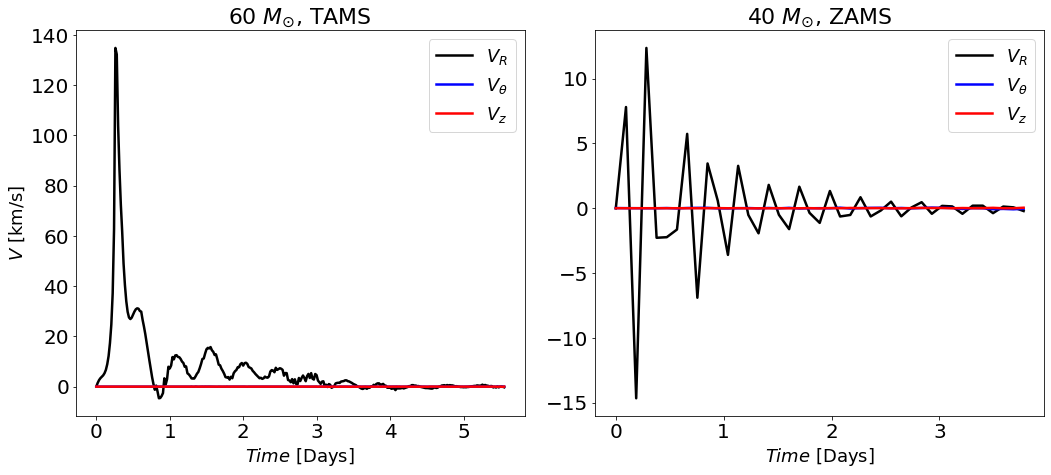

In [33]:
fig, axs=plt.subplots(nrows=1,  ncols=2, figsize=(15,7))
fig.subplots_adjust(hspace=0.3)

axs[0].set_title(r'60 $M_{\odot}$, TAMS', fontsize=22)
axs[0].plot(timeT,VrT,'-k', linewidth=2.5, label = r'$V_{R}$')
axs[0].plot(timeT,VtT,'-b', linewidth=2.5, label = r'$V_{\theta}$')
axs[0].plot(timeT,VzT,'-r', linewidth=2.5, label = r'$V_{z}$')
axs[0].set_ylabel(r'$V$ [km/s]', fontsize = 18)
axs[0].set_xlabel(r'$Time$ [Days]', fontsize = 18)
axs[0].legend(fontsize = 18, loc=0)
#axs[0].set_xlim([1.3,14.5])
#axs[0].set_ylim([-20,60])

axs[1].set_title(r'40 $M_{\odot}$, ZAMS', fontsize=22)
axs[1].plot(timeZ,VrZ,'-k', linewidth=2.5, label = r'$V_{R}$')
axs[1].plot(timeZ,VtZ,'-b', linewidth=2.5, label = r'$V_{\theta}$')
axs[1].plot(timeZ,VzZ,'-r', linewidth=2.5, label = r'$V_{z}$')
axs[1].set_xlabel(r'$Time$ [Days]', fontsize = 18)
axs[1].legend(fontsize = 18, loc=0)
#axs[1].set_xlim([1.3,4.3])
#axs[1].set_ylim([-20,60])

fig.tight_layout()
plt.show()

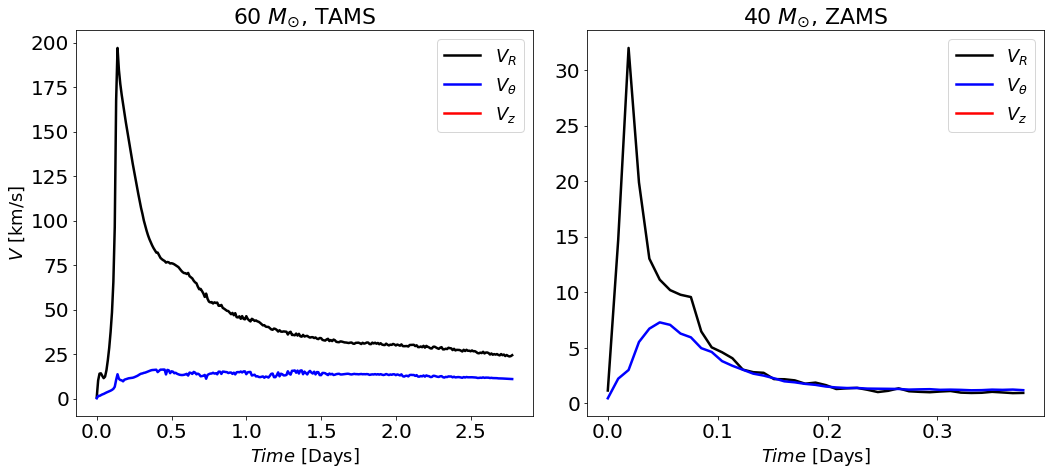

In [22]:
fig, axs=plt.subplots(nrows=1,  ncols=2, figsize=(15,7))
fig.subplots_adjust(hspace=0.3)

axs[0].set_title(r'60 $M_{\odot}$, TAMS', fontsize=22)
axs[0].plot(timeT,stdrT,'-k', linewidth=2.5, label = r'$V_{R}$')
axs[0].plot(timeT,stdtT,'-b', linewidth=2.5, label = r'$V_{\theta}$')
axs[0].plot(timeT,stdzT,'-r', linewidth=2.5, label = r'$V_{z}$')
axs[0].set_ylabel(r'$V$ [km/s]', fontsize = 18)
axs[0].set_xlabel(r'$Time$ [Days]', fontsize = 18)
axs[0].legend(fontsize = 18, loc=0)
#axs[0].set_xlim([1.3,14.5])
#axs[0].set_ylim([-20,60])

axs[1].set_title(r'40 $M_{\odot}$, ZAMS', fontsize=22)
axs[1].plot(timeZ,stdrZ,'-k', linewidth=2.5, label = r'$V_{R}$')
axs[1].plot(timeZ,stdtZ,'-b', linewidth=2.5, label = r'$V_{\theta}$')
axs[1].plot(timeZ,stdzZ,'-r', linewidth=2.5, label = r'$V_{z}$')
axs[1].set_xlabel(r'$Time$ [Days]', fontsize = 18)
axs[1].legend(fontsize = 18, loc=0)
#axs[1].set_xlim([1.3,4.3])
#axs[1].set_ylim([-20,60])

fig.tight_layout()
plt.show()